In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install -q kaggle
!mkdir ~/.kaggle
!cp '/content/drive/MyDrive/kaggle.json' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip -q brain-tumor-mri-dataset.zip -d brain_mri

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0


In [ ]:
import os
base_dir = '/content/brain_mri'
train_dir = os.path.join(base_dir, 'Training')
validation_dir = os.path.join(base_dir, 'Testing')
classes = ['glioma', 'meningioma', 'pituitary', 'notumor']
print("Training Data Distribution:")
for cls in classes:
    class_path = os.path.join(train_dir, cls)
    if os.path.exists(class_path):
        print(f"{cls}: {len(os.listdir(class_path))} images")
print("\nValidation Data Distribution:")
for cls in classes:
    class_path = os.path.join(validation_dir, cls)
    if os.path.exists(class_path):
        print(f"{cls}: {len(os.listdir(class_path))} images")

Training Data Distribution:
glioma: 1321 images
meningioma: 1339 images
pituitary: 1457 images
notumor: 1595 images

Validation Data Distribution:
glioma: 300 images
meningioma: 306 images
pituitary: 300 images
notumor: 405 images


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def normalize_mri(image):
    return (image / 127.5) - 1.0
train_datagen = ImageDataGenerator(
    preprocessing_function=normalize_mri,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(preprocessing_function=normalize_mri)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GRU, Dense, Reshape, Flatten
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Reshape((26*26, 128)),
    GRU(64, return_sequences=True),
    GRU(32),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 676, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 676, 64)             │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 32)                  │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 144,644 (565.02 KB)

 Trainable params: 144,644 (565.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=test_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=50),
        tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)
    ])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.3533 - loss: 1.2985

179/179 ━━━━━━━━━━━━━━━━━━━━ 95s 457ms/step - accuracy: 0.3536 - loss: 1.2981 - val_accuracy: 0.4699 - val_loss: 1.1715
Epoch 2/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.5082 - loss: 1.0312

179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 451ms/step - accuracy: 0.5083 - loss: 1.0311 - val_accuracy: 0.5164 - val_loss: 1.0544
Epoch 3/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step - accuracy: 0.5877 - loss: 0.9333

179/179 ━━━━━━━━━━━━━━━━━━━━ 80s 447ms/step - accuracy: 0.5878 - loss: 0.9332 - val_accuracy: 0.5973 - val_loss: 0.8854
Epoch 4/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.6399 - loss: 0.8511

179/179 ━━━━━━━━━━━━━━━━━━━━ 80s 447ms/step - accuracy: 0.6402 - loss: 0.8507 - val_accuracy: 0.7407 - val_loss: 0.6630
Epoch 5/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 452ms/step - accuracy: 0.7460 - loss: 0.6569 - val_accuracy: 0.7109 - val_loss: 0.7176
Epoch 6/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.8133 - loss: 0.5009

179/179 ━━━━━━━━━━━━━━━━━━━━ 80s 448ms/step - accuracy: 0.8133 - loss: 0.5009 - val_accuracy: 0.8032 - val_loss: 0.5103
Epoch 7/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 455ms/step - accuracy: 0.8349 - loss: 0.4463 - val_accuracy: 0.7811 - val_loss: 0.6288
Epoch 8/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.8535 - loss: 0.3814

179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 455ms/step - accuracy: 0.8536 - loss: 0.3813 - val_accuracy: 0.8589 - val_loss: 0.3807
Epoch 9/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 84s 466ms/step - accuracy: 0.8694 - loss: 0.3534 - val_accuracy: 0.8253 - val_loss: 0.4345
Epoch 10/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.8846 - loss: 0.3185

179/179 ━━━━━━━━━━━━━━━━━━━━ 80s 446ms/step - accuracy: 0.8846 - loss: 0.3184 - val_accuracy: 0.8780 - val_loss: 0.3255
Epoch 11/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 80s 447ms/step - accuracy: 0.8983 - loss: 0.2832 - val_accuracy: 0.8688 - val_loss: 0.3319
Epoch 12/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.8966 - loss: 0.2604

179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 451ms/step - accuracy: 0.8966 - loss: 0.2604 - val_accuracy: 0.8810 - val_loss: 0.3161
Epoch 13/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 79s 442ms/step - accuracy: 0.9271 - loss: 0.2077 - val_accuracy: 0.8604 - val_loss: 0.3582
Epoch 14/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.9198 - loss: 0.2138

179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 460ms/step - accuracy: 0.9198 - loss: 0.2138 - val_accuracy: 0.8856 - val_loss: 0.2956
Epoch 15/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.9276 - loss: 0.2130

179/179 ━━━━━━━━━━━━━━━━━━━━ 86s 479ms/step - accuracy: 0.9277 - loss: 0.2129 - val_accuracy: 0.8894 - val_loss: 0.2793
Epoch 16/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step - accuracy: 0.9242 - loss: 0.2019

179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 456ms/step - accuracy: 0.9242 - loss: 0.2019 - val_accuracy: 0.9283 - val_loss: 0.1851
Epoch 17/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 85s 474ms/step - accuracy: 0.9316 - loss: 0.1795 - val_accuracy: 0.8940 - val_loss: 0.2650
Epoch 18/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 453ms/step - accuracy: 0.9360 - loss: 0.1894 - val_accuracy: 0.8818 - val_loss: 0.3203
Epoch 19/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 457ms/step - accuracy: 0.9405 - loss: 0.1619 - val_accuracy: 0.9237 - val_loss: 0.2036
Epoch 20/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 456ms/step - accuracy: 0.9422 - loss: 0.1681 - val_accuracy: 0.9245 - val_loss: 0.2101
Epoch 21/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 104s 582ms/step - accuracy: 0.9459 - loss: 0.1495 - val_accuracy: 0.9169 - val_loss: 0.2186
Epoch 22/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 87s 484ms/step - accuracy: 0.9525 - loss: 0.1403 - val_accuracy: 0.9115 - val_loss: 0.2537
Epoch 23/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 90s 503ms/step - accuracy: 0.9514 - loss: 0.14

179/179 ━━━━━━━━━━━━━━━━━━━━ 85s 477ms/step - accuracy: 0.9476 - loss: 0.1510 - val_accuracy: 0.9428 - val_loss: 0.1683
Epoch 25/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.9516 - loss: 0.1297

179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 454ms/step - accuracy: 0.9516 - loss: 0.1297 - val_accuracy: 0.9603 - val_loss: 0.1259
Epoch 26/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 460ms/step - accuracy: 0.9607 - loss: 0.1158 - val_accuracy: 0.9268 - val_loss: 0.1963
Epoch 27/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step - accuracy: 0.9576 - loss: 0.1223

179/179 ━━━━━━━━━━━━━━━━━━━━ 83s 466ms/step - accuracy: 0.9576 - loss: 0.1223 - val_accuracy: 0.9573 - val_loss: 0.1168
Epoch 28/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 80s 449ms/step - accuracy: 0.9601 - loss: 0.1088 - val_accuracy: 0.8924 - val_loss: 0.3056
Epoch 29/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9578 - loss: 0.1193

179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 450ms/step - accuracy: 0.9578 - loss: 0.1193 - val_accuracy: 0.9695 - val_loss: 0.0930
Epoch 30/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 83s 464ms/step - accuracy: 0.9614 - loss: 0.1055 - val_accuracy: 0.9161 - val_loss: 0.2399
Epoch 31/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 450ms/step - accuracy: 0.9617 - loss: 0.1065 - val_accuracy: 0.9436 - val_loss: 0.1610
Epoch 32/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 80s 449ms/step - accuracy: 0.9718 - loss: 0.0838 - val_accuracy: 0.9184 - val_loss: 0.2402
Epoch 33/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 80s 448ms/step - accuracy: 0.9601 - loss: 0.1155 - val_accuracy: 0.9573 - val_loss: 0.1379
Epoch 34/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 457ms/step - accuracy: 0.9651 - loss: 0.1010 - val_accuracy: 0.9321 - val_loss: 0.1931
Epoch 35/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 79s 444ms/step - accuracy: 0.9679 - loss: 0.0852 - val_accuracy: 0.9466 - val_loss: 0.1336
Epoch 36/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 455ms/step - accuracy: 0.9766 - loss: 0.067

179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 451ms/step - accuracy: 0.9743 - loss: 0.0772 - val_accuracy: 0.9695 - val_loss: 0.0927
Epoch 38/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 451ms/step - accuracy: 0.9771 - loss: 0.0643 - val_accuracy: 0.9268 - val_loss: 0.2113
Epoch 39/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 79s 439ms/step - accuracy: 0.9771 - loss: 0.0649 - val_accuracy: 0.9603 - val_loss: 0.0969
Epoch 40/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 79s 443ms/step - accuracy: 0.9756 - loss: 0.0643 - val_accuracy: 0.9596 - val_loss: 0.1100
Epoch 41/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step - accuracy: 0.9786 - loss: 0.0579

179/179 ━━━━━━━━━━━━━━━━━━━━ 84s 454ms/step - accuracy: 0.9786 - loss: 0.0579 - val_accuracy: 0.9710 - val_loss: 0.0753
Epoch 42/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 456ms/step - accuracy: 0.9780 - loss: 0.0668 - val_accuracy: 0.9603 - val_loss: 0.0973
Epoch 43/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 453ms/step - accuracy: 0.9715 - loss: 0.0800 - val_accuracy: 0.9474 - val_loss: 0.1443
Epoch 44/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 461ms/step - accuracy: 0.9783 - loss: 0.0591 - val_accuracy: 0.9550 - val_loss: 0.1289
Epoch 45/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 86s 483ms/step - accuracy: 0.9740 - loss: 0.0776 - val_accuracy: 0.9596 - val_loss: 0.1410
Epoch 46/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 81s 452ms/step - accuracy: 0.9754 - loss: 0.0710 - val_accuracy: 0.9657 - val_loss: 0.1025
Epoch 47/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 83s 461ms/step - accuracy: 0.9710 - loss: 0.0827 - val_accuracy: 0.9504 - val_loss: 0.1352
Epoch 48/50
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 456ms/step - accuracy: 0.9777 - loss: 0.070

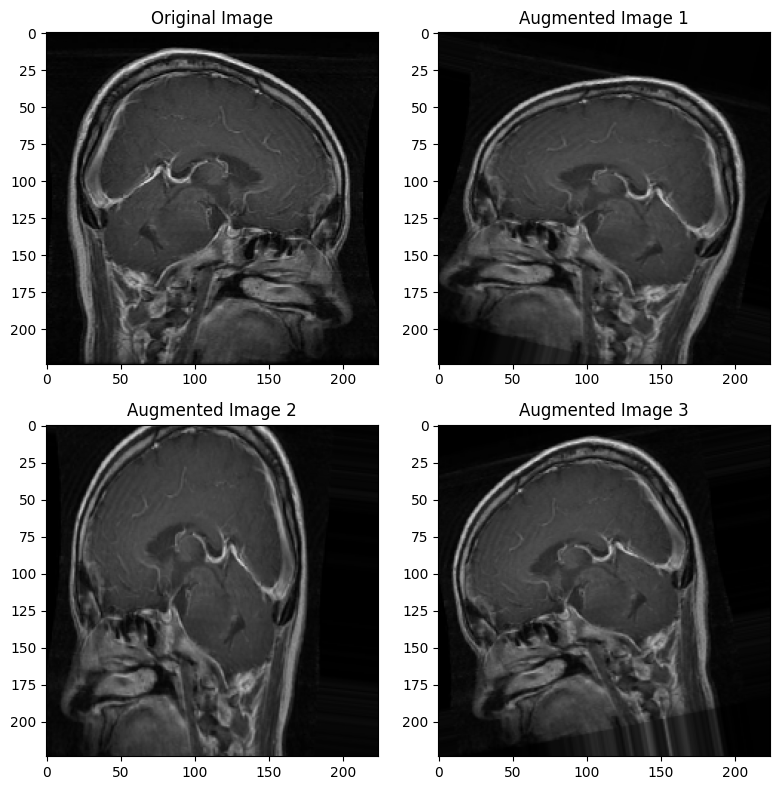

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import os
import matplotlib.pyplot as plt
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
glioma_dir = '/content/brain_mri/Training/glioma'
image_files = [f for f in os.listdir(glioma_dir) if os.path.isfile(os.path.join(glioma_dir, f))]
if image_files:
    img_path = os.path.join(glioma_dir, image_files[0])
    img = load_img(img_path, target_size=(224, 224))
    img_array = img_to_array(img)
    augmented_images = datagen.flow(img_array.reshape((1,) + img_array.shape), batch_size=1)
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 2, 1)
    plt.imshow(img_array / 255.0)
    plt.title("Original Image")
    for i in range(3):
        batch = next(augmented_images)
        plt.subplot(2, 2, i + 2)
        plt.imshow(batch[0] / 255.0)
        plt.title(f"Augmented Image {i + 1}")
    plt.tight_layout()
    plt.show()
else:
    print("No images found in the glioma directory.")

In [ ]:
test_generator = ImageDataGenerator(preprocessing_function=normalize_mri).flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1311 images belonging to 4 classes.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━

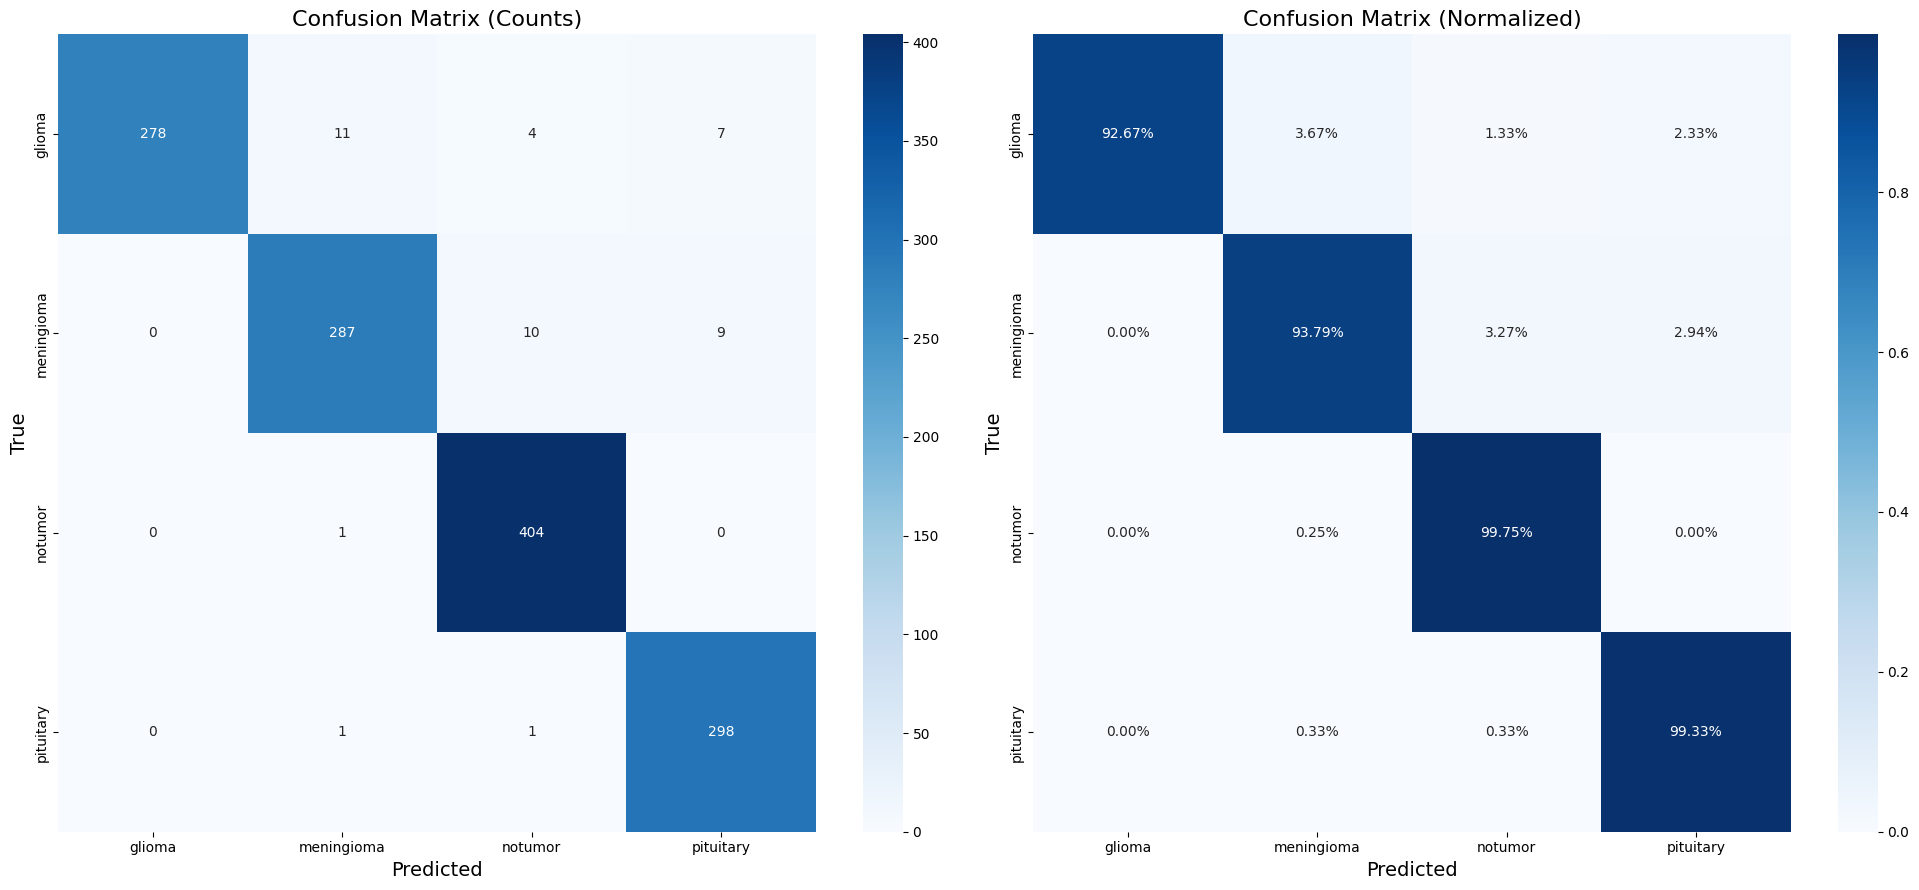


Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.93      0.96       300
  meningioma       0.96      0.94      0.95       306
     notumor       0.96      1.00      0.98       405
   pituitary       0.95      0.99      0.97       300

    accuracy                           0.97      1311
   macro avg       0.97      0.96      0.97      1311
weighted avg       0.97      0.97      0.97      1311



In [ ]:
plot_confusion_matrix(test_generator, model)

In [ ]:
model.save('brain_tumor_model.h5')

Serving 'brain_tumor_model.h5' at http://localhost:17298


('localhost', 17298)

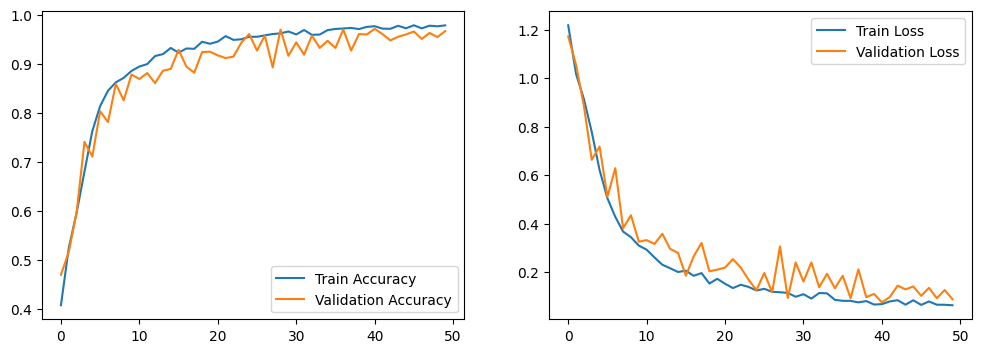

Final Validation Accuracy: 0.9664


In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


41/41 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - accuracy: 0.9434 - loss: 0.1432
Test Loss: 0.0883
Test Accuracy: 0.9664
